In [9]:
import keras
from sklearn.metrics import classification_report
import numpy as np
from keras.utils import load_img, img_to_array
import cv2
#from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
# Get the current working directory
current_directory = os.getcwd()
current_directory

'c:\\Users\\X571\\Downloads\\DeepLearning24_25'

In [11]:
# Define the paths to train and test directories
train_directory = current_directory + '/data_p2/train'
test_directory = current_directory + '/data_p2/test'
val_directory = current_directory + '/data_p2/val'
# Function to count the number of images in a directory
def count_images(directory):
    class_counts = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            class_counts[folder] = len(os.listdir(folder_path))
    return class_counts

# Count images in train and test directories for each class
train_class_counts = count_images(train_directory)
test_class_counts = count_images(test_directory)
val_class_counts = count_images(val_directory)

print("Number of images in each class in the train directory:")
print(train_class_counts)

print("\nNumber of images in each class in the val directory:")
print(val_class_counts)

print("\nNumber of images in each class in the test directory:")
print(test_class_counts)

Number of images in each class in the train directory:
{'adenosis': 267, 'ductal_carcinoma': 2069, 'fibroadenoma': 607, 'lobular_carcinoma': 377, 'mucinous_carcinoma': 475, 'papillary_carcinoma': 337, 'phyllodes_tumor': 272, 'tubular_adenoma': 341}

Number of images in each class in the val directory:
{'adenosis': 88, 'ductal_carcinoma': 691, 'fibroadenoma': 204, 'lobular_carcinoma': 124, 'mucinous_carcinoma': 159, 'papillary_carcinoma': 111, 'phyllodes_tumor': 91, 'tubular_adenoma': 114}

Number of images in each class in the test directory:
{'adenosis': 89, 'ductal_carcinoma': 691, 'fibroadenoma': 203, 'lobular_carcinoma': 125, 'mucinous_carcinoma': 158, 'papillary_carcinoma': 112, 'phyllodes_tumor': 90, 'tubular_adenoma': 114}


In [12]:
source_folders = ['adenosis', # benign
                  'fibroadenoma', # benign
                  'phyllodes_tumor', # benign
                  'tubular_adenoma', # benign
                  'ductal_carcinoma', # malighant
                  'lobular_carcinoma', # malighant
                  'mucinous_carcinoma', # malighant
                  'papillary_carcinoma'] # malighant

# Initialize empty lists for train and test data
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

# Function to resize images and create numpy arrays
def resize_and_create_arrays(directory, X, y, target_size=(128, 128)):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path) and folder in source_folders:
            label = source_folders.index(folder)  # 0 for benign, 1 for malignant
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    with Image.open(file_path) as img:
                        # Resize image to target size
                        img_resized = img.resize(target_size)
                        # Convert image to numpy array
                        img_array = np.array(img_resized)
                        # Append image array to X and label to y
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Resize images and create arrays for the train directory
resize_and_create_arrays(train_directory, X_train, y_train)

# Resize images andcreate arrays for the val directory
resize_and_create_arrays(val_directory, X_val, y_val)

# Resize images andcreate arrays for the test directory
resize_and_create_arrays(test_directory, X_test, y_test)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print dataset information
print("Resized images and created X and y arrays.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Resized images and created X and y arrays.
X_train shape: (4745, 128, 128, 3)
y_train shape: (4745,)
X_val shape: (1582, 128, 128, 3)
y_val shape: (1582,)
X_test shape: (1582, 128, 128, 3)
y_test shape: (1582,)


In [13]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [14]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [15]:
X_train = tf.constant(X_train, dtype='float32')
X_test = tf.constant(X_test, dtype='float32')
X_val = tf.constant(X_val, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')

In [16]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1:])))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [17]:
# Train the model
history = model.fit(
    X_train, y_train, 
    batch_size=150, 
    epochs=100, 
    validation_data=[X_val, y_val], 
    verbose=1, 
    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
32/32 [==============================] - 79s 2s/step - loss: 1.9710 - accuracy: 0.2938 - val_loss: 1.8199 - val_accuracy: 0.4368 - lr: 1.0000e-04
Epoch 2/100
32/32 [==============================] - 73s 2s/step - loss: 1.8874 - accuracy: 0.3463 - val_loss: 1.7209 - val_accuracy: 0.4368 - lr: 1.0000e-04
Epoch 3/100
32/32 [==============================] - 67s 2s/step - loss: 1.8205 - accuracy: 0.3722 - val_loss: 1.7011 - val_accuracy: 0.4678 - lr: 1.0000e-04
Epoch 4/100
32/32 [==============================] - 67s 2s/step - loss: 1.7980 - accuracy: 0.3779 - val_loss: 1.6511 - val_accuracy: 0.4564 - lr: 1.0000e-04
Epoch 5/100
32/32 [==============================] - 67s 2s/step - loss: 1.7729 - accuracy: 0.4008 - val_loss: 1.6742 - val_accuracy: 0.5082 - lr: 1.0000e-04
Epoch 6/100
32/32 [==============================] - 67s 2s/step - loss: 1.7412 - accuracy: 0.4118 - val_loss: 1.6185 - val_accuracy: 0.4930 - lr: 1.0000e-04
Epoch 7/100
32/32 [==============================] -

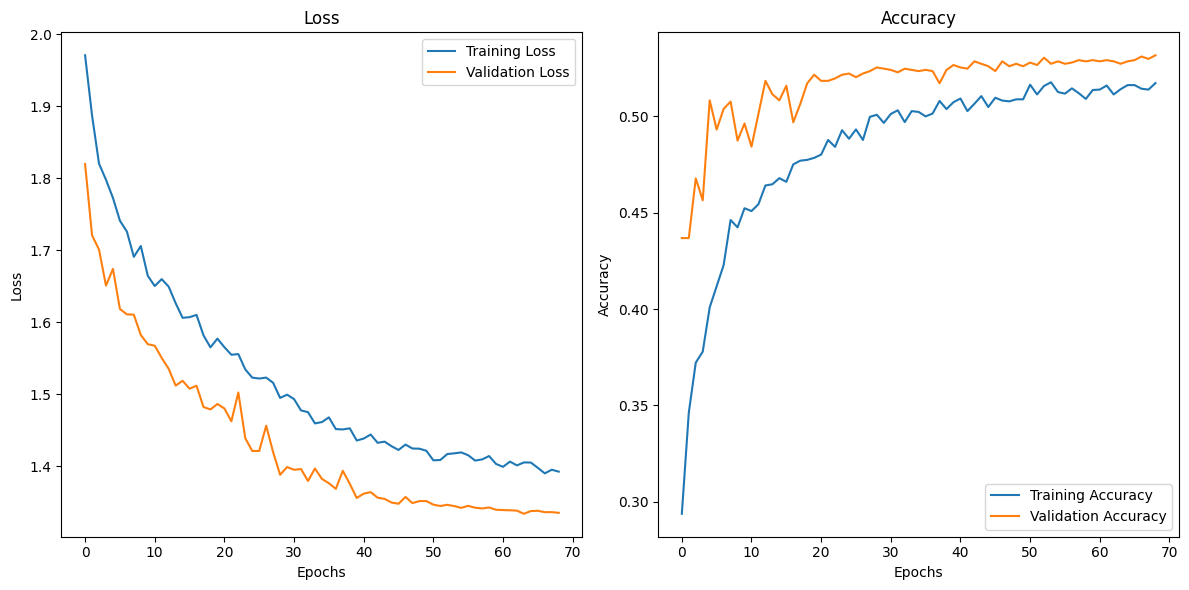

In [18]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
y_test_predicted = model.predict(X_test)
y_test_predicted = [float(el.argmax()) for el in y_test_predicted]

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}\n\n')

print(classification_report(y_test, y_test_predicted))

50/50 [==============================] - 5s 97ms/step - loss: 1.3453 - accuracy: 0.5202
Test Loss: 1.3452588319778442
Test Accuracy: 0.5202275514602661


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        89
         1.0       0.35      0.70      0.47       203
         2.0       0.00      0.00      0.00        90
         3.0       0.81      0.15      0.25       114
         4.0       0.58      0.96      0.72       691
         5.0       0.00      0.00      0.00       125
         6.0       0.00      0.00      0.00       158
         7.0       0.00      0.00      0.00       112

    accuracy                           0.52      1582
   macro avg       0.22      0.23      0.18      1582
weighted avg       0.35      0.52      0.39      1582



c:\Users\X571\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\X571\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\X571\anaconda3\envs\deep_learning\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",